# COGS 108 - Final Project

## Important

- ONE, and only one, member of your group should upload this notebook to TritonED. 
- Each member of the group will receive the same grade on this assignment. 
- Keep the file name the same: submit the file 'FinalProject.ipynb'.
- Only upload the .ipynb file to TED, do not upload any associted data. Make sure that for cells in which you want graders to see output that these cells have been executed.

In [76]:
# Imports
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

## Group Members: Fill in the Student IDs of each group member here

Replace the lines below to list each persons full student ID, ucsd email and full name.

-  A92037564, miz060@ucsd.edu, Mingcheng Zhu
-  A92046816, zhw158@ucsd.edu, Zhihao Wang
- 
- 



## Part 1 - Data Wrangling

Quoted from Kaggle (As it is a well-written summary of the provided dataset):

"In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves."

We are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

we use the train_V2.csv dataset from the Kaggle competition: PUBG Finish Placement Prediction
https://www.kaggle.com/c/pubg-finish-placement-prediction/data
Our dataset and its columns are:

- `train_V2.csv`: Contains one row for each player in a specific game. The columns we used are 
    - `damageDealt`: Total damage dealt. Note: Self inflicted damage is subtracted.
    - `kills`: Number of enemy players killed.
    - `matchDuration`: Duration of match in seconds.
    - `rideDistance`: Total distance traveled in vehicles measured in meters.
    - `swimDistance`: Total distance traveled by swimming measured in meters.
    - `walkDistance`: Total distance traveled on foot measured in meters.
    - `winPlacePerc`: This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. 

Load the `train_V2.csv` file into a `pandas` DataFrame named `df`. 

In [77]:
df = pd.read_csv('train_V2.csv',nrows=50000)

Drop any rows with missing data.

In [78]:
df = df.dropna(how='any')

For our project, the focused data columns are damage dealt, kill numbers, movement data and victory percentage. As result, all irrelavent columns are dropped.

In [79]:
df = df.drop(columns=['Id', 'groupId', 'winPoints','matchId', 'killPlace', 'matchType', 'assists', 'boosts', 'maxPlace', 'DBNOs', 'headshotKills', 'heals', 'killPoints', 'killStreaks', 'longestKill', 'numGroups', 'rankPoints', 'revives', 'roadKills', 'teamKills', 'vehicleDestroys', 'weaponsAcquired'])

Player who gets eliminated right after the beginning of the game tends to have fewer movements than those who continue to survive after the initial conflicts. Therefore, to reduce this bias, we only include players whose game duration time (for individual matches) is among the top 75% of all players.

In [80]:
df['matchDuration'].describe().apply(lambda x: format(x, 'f'))

count    50000.000000
mean      1578.475840
std        258.964510
min        209.000000
25%       1366.000000
50%       1437.000000
75%       1850.000000
max       2218.000000
Name: matchDuration, dtype: object

In [81]:
df = df.drop(df.loc[df['matchDuration'] < 1367].index)

The below is a overview of our cleaned raw data set.

In [82]:
df

,damageDealt,kills,matchDuration,rideDistance,swimDistance,walkDistance,winPlacePerc
1,91.470,0,1777,0.0045,11.040,1434.000,0.6400
3,32.900,0,1436,0.0000,0.000,202.700,0.1667
4,100.000,1,1424,0.0000,0.000,49.750,0.1875
5,100.000,1,1395,0.0000,0.000,34.700,0.0370
7,8.538,0,1967,2004.0000,0.000,1089.000,0.7368
8,51.600,0,1375,0.0000,0.000,799.900,0.3704
9,37.270,0,1930,0.0000,0.000,65.670,0.2143
10,28.380,0,1811,0.0000,0.000,868.300,0.3929
11,137.900,0,1384,0.0000,0.000,451.700,0.4043
12,0.000,0,1774,6639.0000,0.000,2784.000,0.9286


As discussed in the proposal, when measuring movement tendencies, we will use the matrix of distance per gameTime, which measures the player’s movement distance per game time in the unit of meters per second. 

The formula for calculating the player’s movement tendency in a game will be:

Movement Tendency = (swimDistance + rideDistance + walkDistance) / matchDuration

In [83]:
def movement_tendency(row):
    d = float((row['swimDistance'] + row['rideDistance'] + row['walkDistance']) / row['matchDuration'] * 100)
    return d

To create easier access to this information, we add a new column to the data frame based on values from other ones.

In [84]:
df['moveTendency'] = df.apply (lambda row: movement_tendency(row), axis=1)

After calculating the movement tendency column, we drop more columns for readability.

In [85]:
df = df.drop(columns=['matchDuration', 'rideDistance', 'swimDistance', 'walkDistance'])

We will drop any kills above 30 to ensure that hackers do not count toward our model.

In [86]:
df=df[df.kills<=30]

The below is a brief describtion of the data frame that we will explore in the following sections.

In [87]:
df.describe()

,damageDealt,kills,winPlacePerc,moveTendency
count,37460.000000,37460.000000,37460.000000,37460.000000
mean,130.473654,0.910438,0.474318,114.609095
std,167.575476,1.501137,0.307571,129.802076
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.200000,11.098002
50%,83.200000,0.000000,0.461500,57.497353
75%,185.400000,1.000000,0.744700,190.938383
max,2767.000000,22.000000,1.000000,1388.944034


## Part 2: Exploratory Data Vizualization

First, we need to do some exploratory data visualization, to get a feel for the data. 

For each column, we plot a histogram to get a feeling about the dataset's shape.
We didn't include a scatter matrix in this section as it takes too much runtime to be pratical, and we don't need any particular information from it.

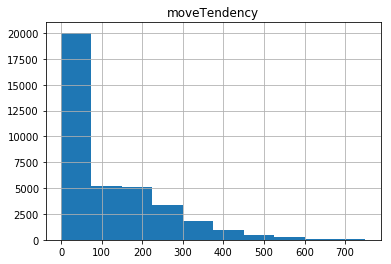

In [88]:
df.hist(column='moveTendency', range=[0, 750])
f2 = plt.gcf()

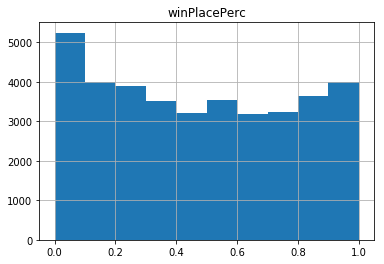

In [89]:
df.hist(column='winPlacePerc')
f2 = plt.gcf()

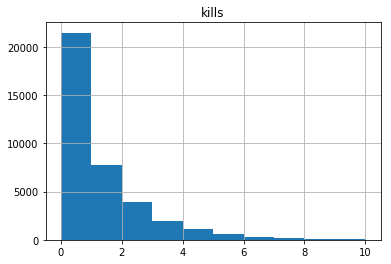

In [90]:
df.hist(column='kills', range=[0, 10])
f2 = plt.gcf()

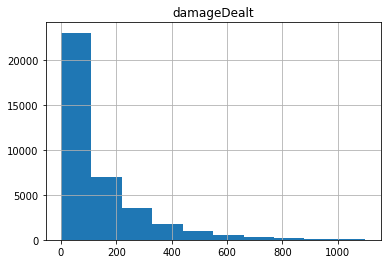

In [91]:
df.hist(column='damageDealt', range=[0, 1100])
f2 = plt.gcf()

## Part 3: Data analysis and result

### 3(a) relationship between kills, move distance and possibility to win.

First we drop damage dealt colume to get rid of abundant data.

In [92]:
df_kill=df.drop(columns=['damageDealt'])

In [93]:
df_kill.head(5)

,kills,winPlacePerc,moveTendency
1,0,0.6400,81.319330
3,0,0.1667,14.115599
4,1,0.1875,3.493680
5,1,0.0370,2.487455
7,0,0.7368,157.244535


By unique(), we can see all the kills number in general. 

In [94]:
df_kill['kills'].unique()

array([ 0,  1,  4,  2,  9,  3,  5,  6,  8, 13,  7, 12, 21, 14, 11, 17, 10,
       15, 16, 22])

check the types and length of df_kills

In [95]:
df_kill['kills'] = df_kill['kills'].astype(np.int64)

In [96]:
df_kill['moveTendency']=df_kill['moveTendency'].astype(np.float64)

In [97]:
df_kill['winPlacePerc']=df_kill['winPlacePerc'].astype(np.float64)

In [98]:
len_kill=len(df_kill)


Plot the data, using scatter_matrix, from Pandas. Assign it to a variable called 'fig'.

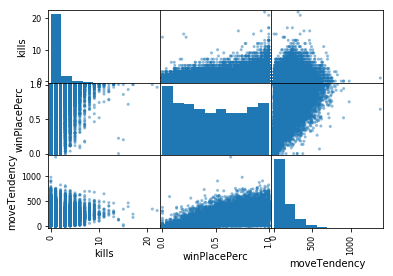

In [99]:
fig=pd.plotting.scatter_matrix(df_kill)

Kills distribution

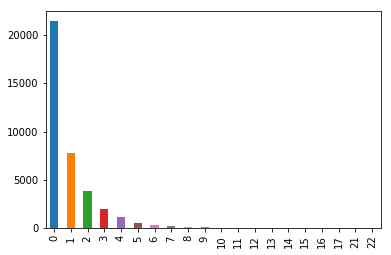

In [100]:
df_kill['kills'].value_counts().plot(kind='bar')
f1 = plt.gcf()

Now, clearly it is not normal distribution, but since it is PUBG, lots of people does not need to kill to win. So it is ok if we just keep it like that.

Next, we use pivot table to find out the correlation among kills, moveTendency and win rate.

In [101]:
pv=pd.pivot_table(df_kill,values='winPlacePerc',index=['kills','moveTendency'])


Visualize the pivot table

In [102]:
pv

winPlacePerc
kills moveTendency              
0     0.000000           0.03758
      0.000021           0.07410
      0.001184           0.47920
      0.001878           0.25930
      0.002004           0.12770
      0.002159           0.14810
      0.002255           0.11110
      0.002976           0.07410
      0.003290           0.18520
      0.004434           0.01060
      0.007087           0.36170
      0.007532           0.20000
      0.008179           0.07690
      0.008184           0.03700
      0.009749           0.13980
      0.009846           0.10340
      0.011033           0.12370
      0.011621           0.46150
      0.012964           0.07140
      0.013290           0.03450
      0.013679           0.15790
      0.014189           0.10870
      0.014553           0.03700
      0.014660           0.53850
      0.014799           0.43480
      0.014823           0.28570
      0.014886           0.83330
      0.015152           0.04760
      0.015828           0.50000
      0.015918           0.04170
...                          ...
11    347.478368         0.89580
      489.300412         1.00000
      648.705758         0.92860
12    217.101147         0.77780
      240.647285         0.78570
      261.399177         0.89900
      301.320655         0.91490
      318.756699         1.00000
      399.946581         0.93620
      409.734728         0.96430
      470.840384         0.89290
13    185.243553         1.00000
      247.666667         1.00000
      272.587719         1.00000
      282.377696         1.00000
      285.911402         1.00000
      307.019438         0.96150
      462.212240         1.00000
14    117.032164         0.00000
      130.258490         1.00000
      138.375973         0.22220
15    0.967670           0.20000
      28.534002          0.85710
      340.635268         1.00000
16    390.957731         0.92860
      466.539510         0.71430
17    173.535792         1.00000
      239.816810         1.00000
21    342.223837         1.00000
22    313.212573         0.96150

[36579 rows x 1 columns]

Now, we need to make a linear model using OLS to predict relation between kills and win rate.

In [103]:
outcome_1, predictors_1=patsy.dmatrices('winPlacePerc~kills',df_kill)
mod_1=sm.OLS(outcome_1, predictors_1)
res_1=mod_1.fit()

In [104]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     8350.
Date:                Tue, 19 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:36:55   Log-Likelihood:                -5216.6
No. Observations:               37460   AIC:                         1.044e+04
Df Residuals:                   37458   BIC:                         1.045e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3947      0.002    234.829      0.0

Also, we can use a scatter plot to show the win rate-kills relationship.

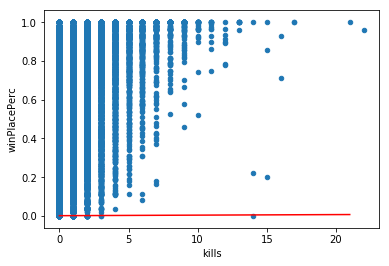

In [105]:
a1, b1 = np.polyfit(df_kill.kills, df_kill.winPlacePerc, deg=1)
pred_kill=(a1*np.arange(0,22)+b1)/pred_kill.max()
df_kill.plot.scatter(x='kills', y='winPlacePerc')
plt.plot(np.arange(0, 22), pred_kill, color='r')
f1 = plt.gcf()


##### conclusion1:By the graph and table, we can see that more kills results in higher win rate.

we need to make a linear model using OLS to predict relation between move tendency and win rate.

In [106]:
outcome_2, predictors_2=patsy.dmatrices('winPlacePerc~moveTendency',df_kill)
mod_2=sm.OLS(outcome_2, predictors_2)
res_2=mod_2.fit()

In [107]:
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                 4.270e+04
Date:                Tue, 19 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:36:56   Log-Likelihood:                 5262.5
No. Observations:               37460   AIC:                        -1.052e+04
Df Residuals:                   37458   BIC:                        -1.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2761      0.001    190.522   

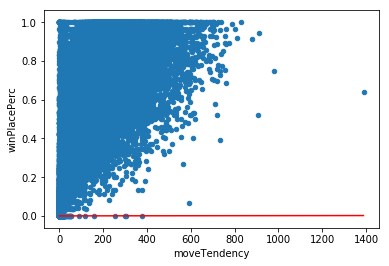

In [108]:
a2, b2 = np.polyfit(df_kill.moveTendency, df_kill.winPlacePerc, deg=1)
pred_move=(a2*np.arange(0,1389)+b2)/df['moveTendency'].max()
df_kill.plot.scatter(x='moveTendency', y='winPlacePerc')
plt.plot(np.arange(0, 1389), pred_move, color='r')
f1 = plt.gcf()



###### conclusion 2: from above table and graph, we can see that move tendency does not affect win rate that much.